# Transfer Learning

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from modules import data_setup, engine
import os
from pathlib import Path

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for torchvision.models (manual creation)

In [44]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [45]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2470df24350>,
 ['pizza', 'steak', 'sushi'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


red.shape: (512, 512)
red mean: 137.91679763793945
green mean: 110.43733215332031
t2_image_red.shape: torch.Size([224, 224])
t2_image_red mean: 0.5408787131309509
t2_image_green mean: 0.43310269713401794
transformed_image_red.shape: torch.Size([224, 224])
transformed_image_red mean: 0.0038370508700609207
transformed_image_green mean: -0.1022200658917427


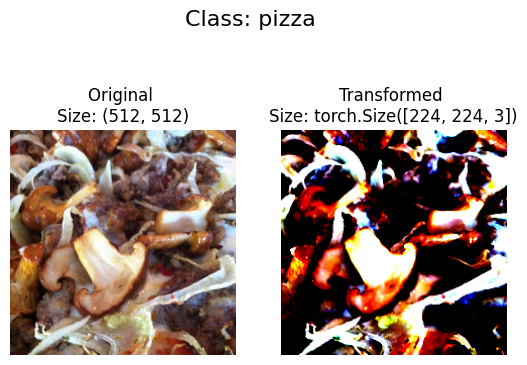

In [60]:
# Plot some transformed images
from modules import plot_utils
from PIL import Image
import numpy

image_paths = list(train_dir.glob("**/*.jpg"))
plot_utils.plot_transformed_images([image_paths[20]], manual_transforms, n=1, seed=42)

t2 = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
])

image_path = image_paths[20]
with Image.open(image_path) as f:
  # image to numpy array
  image_array = numpy.array(f)
  red = image_array[:, :, 0]
  green = image_array[:, :, 1]
  print(f"red.shape: {red.shape}")
  print(f"red mean: {red.mean()}")
  print(f"green mean: {green.mean()}")
  
  t2_image = t2(f).permute(1, 2, 0)
  t2_image_red = t2_image[:, :, 0]
  t2_image_green = t2_image[:, :, 1]
  print(f"t2_image_red.shape: {t2_image_red.shape}")
  print(f"t2_image_red mean: {t2_image_red.mean()}")
  print(f"t2_image_green mean: {t2_image_green.mean()}")
  
  transformed_image = manual_transforms(f).permute(1, 2, 0)
  transformed_image_red = transformed_image[:, :, 0]
  transformed_image_green = transformed_image[:, :, 1]
  print(f"transformed_image_red.shape: {transformed_image_red.shape}")
  print(f"transformed_image_red mean: {transformed_image_red.mean()}")
  print(f"transformed_image_green mean: {transformed_image_green.mean()}")



### 2.2 Creating a transform for torchvision.models (auto creation)

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1246d6fb9d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

In [9]:
import torchinfo
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112


### 3.4 Freezing the base model and changing the output layer to suit our needs

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [12]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
torchinfo.summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Training the model

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0945 | train_acc: 0.4062 | test_loss: 0.8764 | test_acc: 0.7008
Epoch: 2 | train_loss: 0.8544 | train_acc: 0.8125 | test_loss: 0.7410 | test_acc: 0.8854
Epoch: 3 | train_loss: 0.8104 | train_acc: 0.7031 | test_loss: 0.6732 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7049 | train_acc: 0.7578 | test_loss: 0.6466 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.6263 | train_acc: 0.7539 | test_loss: 0.5787 | test_acc: 0.8759
[INFO] Total training time: 79.355 seconds


## 5. Evaluate model by plotting loss curves

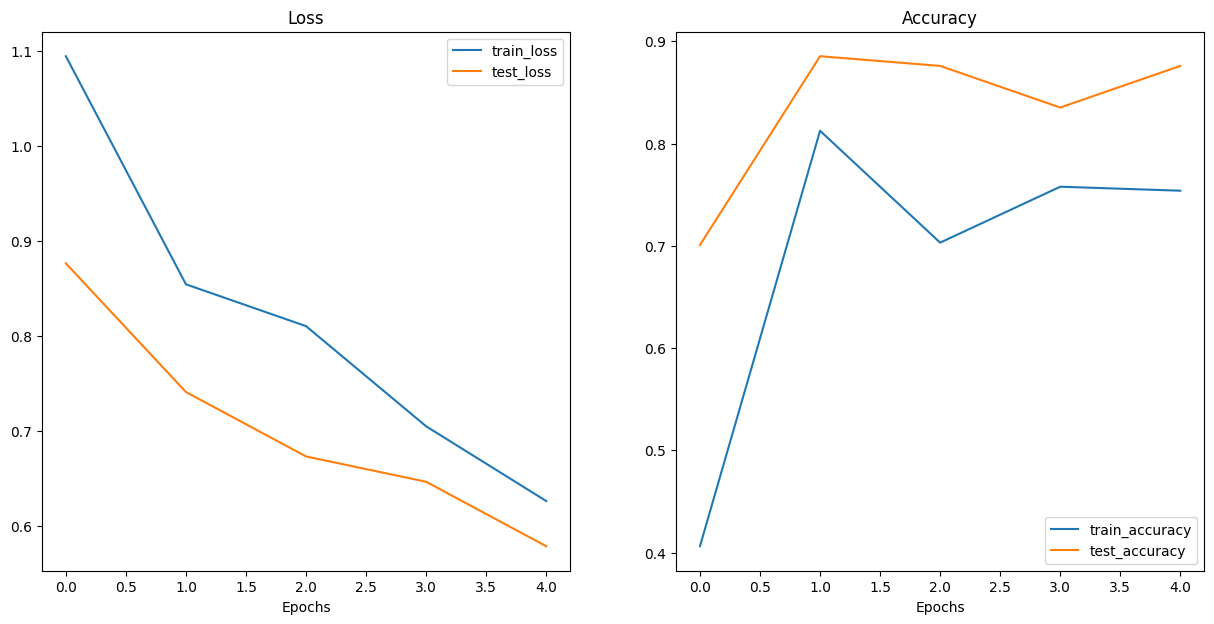

In [15]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions

In [16]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

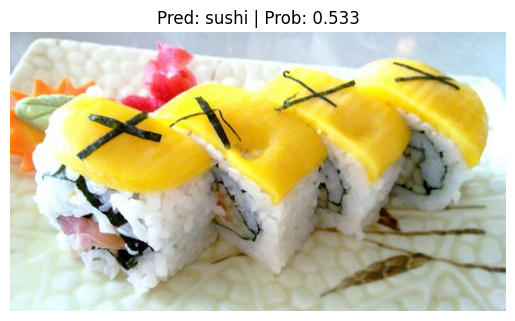

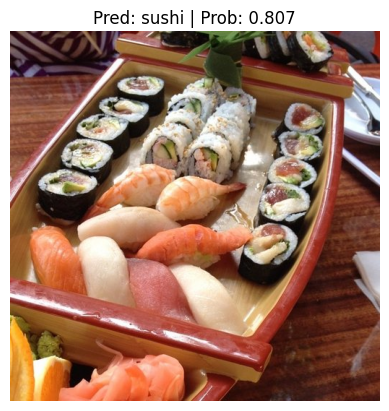

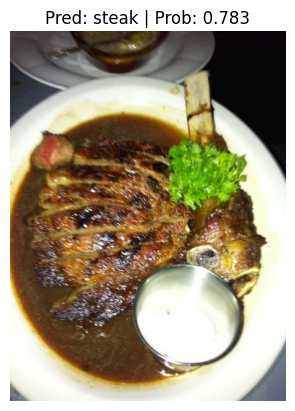

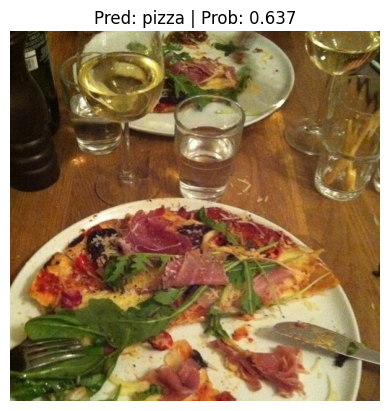

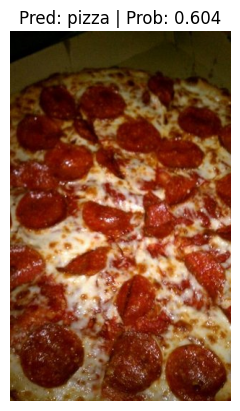

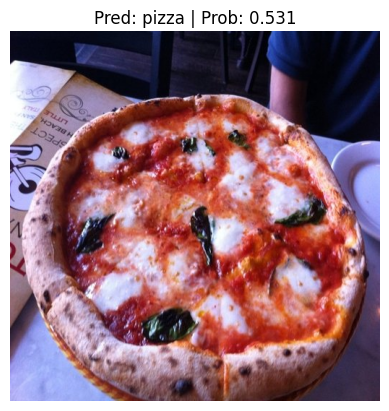

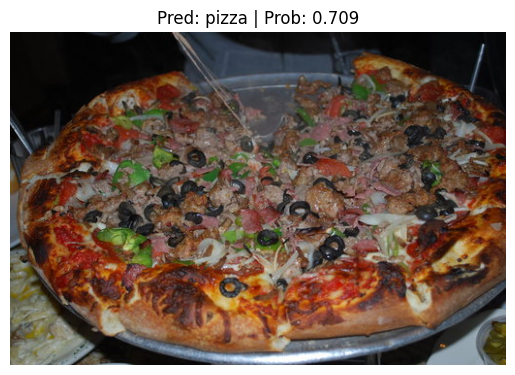

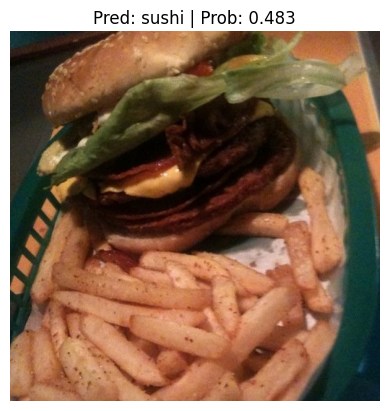

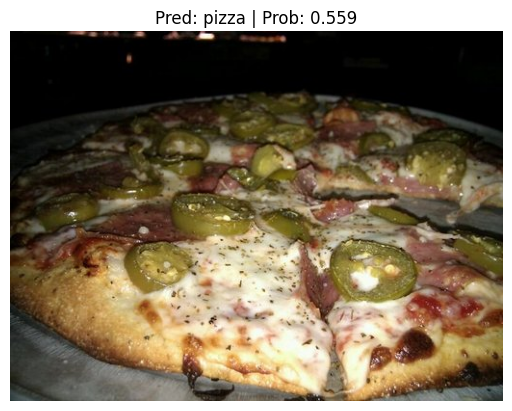

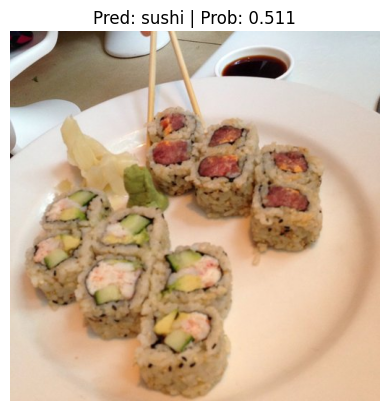

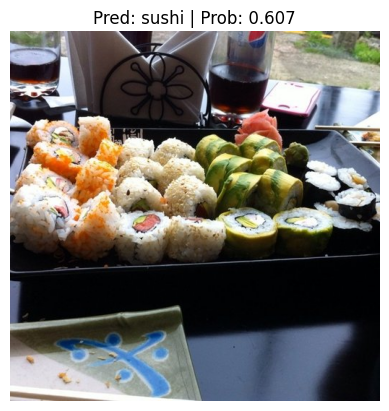

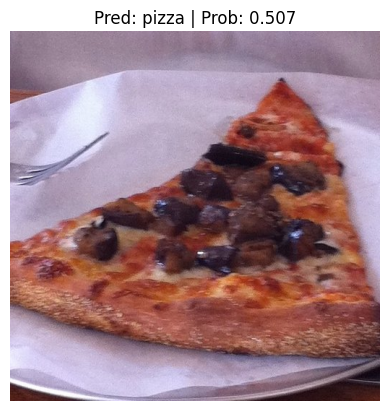

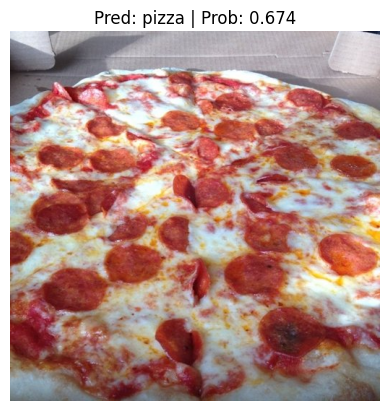

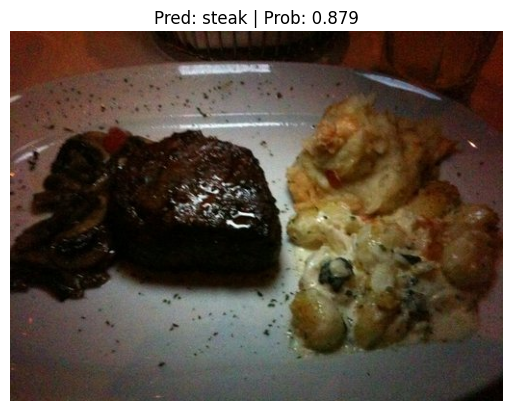

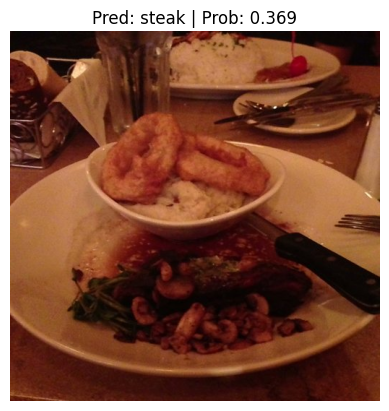

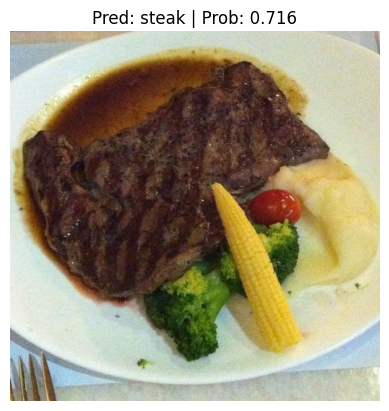

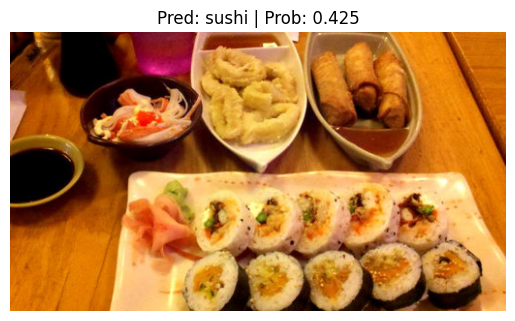

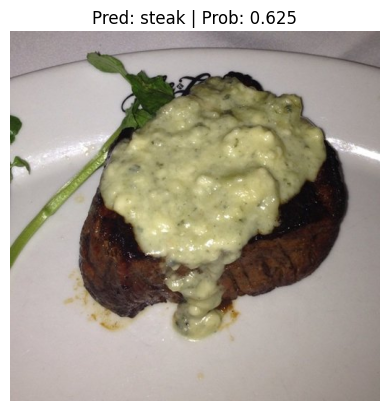

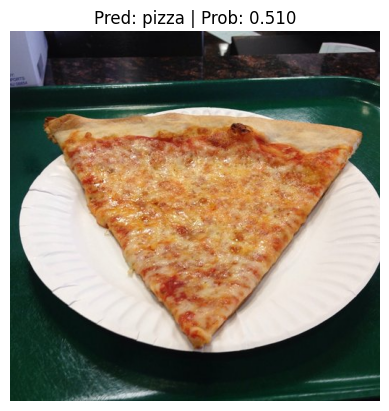

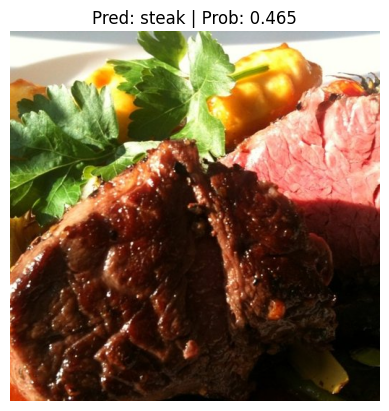

In [17]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 20
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

data\04-pizza-dad.jpeg already exists, skipping download.


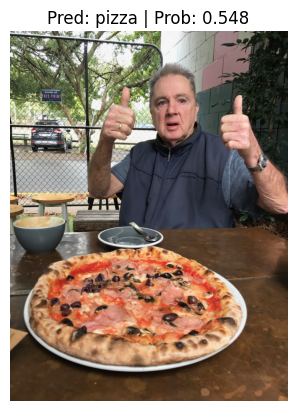

In [18]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# 8. Bigger Model

In [19]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [20]:
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7517 | train_acc: 0.8164 | test_loss: 0.6833 | test_acc: 0.8883
Epoch: 2 | train_loss: 0.6752 | train_acc: 0.7969 | test_loss: 0.6248 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.6306 | train_acc: 0.9219 | test_loss: 0.6010 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.6382 | train_acc: 0.9141 | test_loss: 0.6036 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.6065 | train_acc: 0.7891 | test_loss: 0.5587 | test_acc: 0.9384
[INFO] Total training time: 79.478 seconds
